<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/Image%20Segmentation%20FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.executing_eagerly()

True

In [4]:
!wget https://github.com/shubham0204/Dataset_Archives/blob/master/cityscape_images.zip?raw=true -O cityscape_images.zip
!unzip cityscape_images.zip
print()

--2020-05-11 09:33:21--  https://github.com/shubham0204/Dataset_Archives/blob/master/cityscape_images.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/shubham0204/Dataset_Archives/raw/master/cityscape_images.zip [following]
--2020-05-11 09:33:22--  https://github.com/shubham0204/Dataset_Archives/raw/master/cityscape_images.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/cityscape_images.zip [following]
--2020-05-11 09:33:22--  https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/cityscape_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [0]:
IMG_PATH = "cityscape_images/images"
BATCH_SIZE = 32 #@param {type: "number"}
BUFFER_SIZE = 2000 #@param {type: "number"}
TRAIN_LENGTH = 800 #@param {type: "number"}
DROPOUT_RATE = 0.4  #@param {type: "number"}
NUM_CHANNELS = 4 #@param {type: "number"}

IMG_HEIGHT = 224
IMG_WIDTH = 224

images = tf.data.Dataset.list_files(f"{IMG_PATH}/*.jpg")

In [0]:
def read_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  feature = tf.image.resize(image[:, :256, :], (IMG_HEIGHT, IMG_WIDTH))
  label = tf.image.resize(image[:, 256:, :], (IMG_HEIGHT, IMG_WIDTH))
  
  return (feature, label)

ds = images.map(read_image).shuffle(BUFFER_SIZE)

train_ds = ds.take(TRAIN_LENGTH).batch(BATCH_SIZE)
valid_ds = ds.skip(TRAIN_LENGTH).batch(BATCH_SIZE)

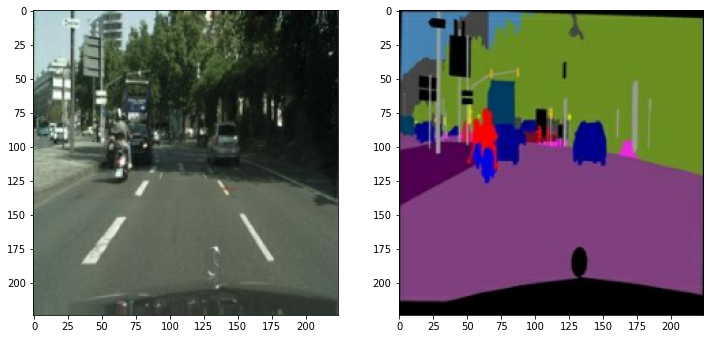

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
sample_image = next(iter(ds.take(1)))
ax[0].imshow(sample_image[0])
ax[1].imshow(sample_image[1])

In [0]:
def build_vgg16_encoder(input_shape):
  inputs = keras.layers.Input(shape=input_shape)
  # Layer 1
  e = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  e = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e1 = e

  # Layer 2
  e = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e2 = e

  # Layer 3
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e3 = e

  # Layer 4
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e4 = e

  # Layer 5
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e5 = e

  return inputs, [e1, e2, e3, e4, e5]

In [0]:
def crop(o1, o2, i):
  o_shape2 = keras.Model(i, o2).output_shape
  output_height2 = o_shape2[1]
  output_width2 = o_shape2[2]

  o_shape1 = keras.Model(i, o1).output_shape
  output_height1 = o_shape1[1]
  output_width1 = o_shape1[2]

  cx = abs(output_width1 - output_width2)
  cy = abs(output_height2 - output_height1)

  if output_width1 > output_width2:
      o1 = keras.layers.Cropping2D(cropping=((0, 0),  (0, cx)))(o1)
  else:
      o2 = keras.layers.Cropping2D(cropping=((0, 0),  (0, cx)))(o2)

  if output_height1 > output_height2:
      o1 = keras.layers.Cropping2D(cropping=((0, cy),  (0, 0)))(o1)
  else:
      o2 = keras.layers.Cropping2D(cropping=((0, cy),  (0, 0)))(o2)

  return o1, o2

def build_fcn8(encoder):
  # ENCODER - can be replaced with any other arch.
  img_input, [e1, e2, e3, e4, e5] = encoder(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # FULLY CONVOLUTIONAL LAYERS
  o = keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(e5)
  o = keras.layers.Dropout(DROPOUT_RATE)(o)

  o = keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(o)
  o = keras.layers.Dropout(DROPOUT_RATE)(o)

  o = keras.layers.Conv2D(NUM_CHANNELS, (1, 1), activation='relu', padding='same')(o) # Classifying Layer

  # DECODER
  # Fuse 1
  d = keras.layers.Conv2DTranspose(NUM_CHANNELS, (4, 4), strides=(2, 2), padding='same')(o)
  d2 = keras.layers.Conv2D(NUM_CHANNELS, (1, 1))(e4)
  d, d2 = crop(d, d2, img_input)
  d = keras.layers.Add()([d, d2])
  print(d)

In [2]:
build_fcn8(build_vgg16_encoder)

NameError: ignored